## An example how to calculate sdg 11.2 indicator for Nairobi

This is an example on how to calculate the SDG11.2.1 indicator for the city of Nairobi. You have to keep in mind that
 this is a full example of Nairobi with its 4.3 Million inhabitants. In this example you have to download whole the
 street network of the nairobi region (around 800.000 edges) and route from 332.000 points with population
information to around 2700 public transport
stops. Therefore, this will take some time to run (depending on your computer at least 1-2 hours).

We start by importing all necessary libraries and setting our project path to the system paths.

In [5]:
import os
import sys
project_path = os.path.abspath('../')
sys.path.append(project_path)
import geopandas as gpd
from matplotlib import pyplot as plt

from ptac import accessibility as accessibility
from ptac import osm as osm
from ptac import population as population

Next, you might load public transport stops from disk.

In [6]:
stops_high_capacity = gpd.read_file(project_path + "/data/nairobi_pt_high.gpkg")
stops_low_capacity = gpd.read_file(project_path + "/data/nairobi_pt_low.gpkg")

and generate a Point GeoDataFrame with population information from a WSF raster dataset

In [7]:
population_points = population.raster_to_points(project_path + "/data/nairobi_population_raster.tif")


you can write this point dataset to disk as a geopackage file (which you can also use in your local GIS) and/or
load it again from disk

In [8]:
population_points.to_file(project_path + "/data/nairobi_population.gpkg", driver="GPKG")
population_points = gpd.read_file(project_path + "/data/nairobi_population.gpkg")

You might want to generate a boundary of the population dataset using the convex hull function of geopandas.
The boundary is necessary as a bounding box to download the road network.

In [9]:
boundary_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326',
                                geometry=[population_points.unary_union.convex_hull])

You can plot the stops and the boundary now to check if everything worked correctly

<AxesSubplot:>

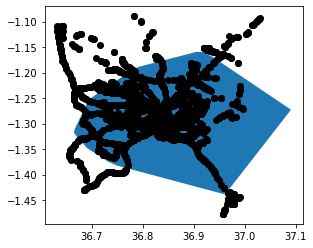

In [10]:
ax = boundary_gdf.plot()
stops_low_capacity.plot(color="black", ax=ax)

or you might want to plot the population and pt stops (this may take some time since the data sets are relatively big)

In [ ]:
population_points.plot(column= "pop", cmap='OrRd', legend=True)
plt.show()

now, you can calculate sum of population in the focus area

In [ ]:
population_sum = population_points["pop"].sum()

print(f"Overall sum of population is: {population_sum}")

and download the network before calculating. As you have to download and process the whole road network for Nairobi,
this also takes some time.

In [9]:
network_gdf = osm.get_network(boundary_gdf)

Then, we can have a look at the network..

KeyboardInterrupt: 

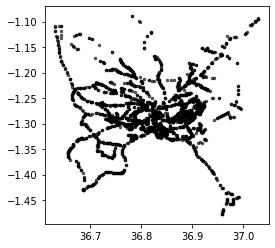

In [10]:
ax = stops_low_capacity.plot(color="black", markersize=6, alpha=0.6)
network_gdf.plot(color="grey", linewidth=0.2, ax=ax)
plt.show()

.. and store it to disk. You are able to drag and drop this data set into your GIS software from the data folder within
this project.

In [ ]:
network_gdf.to_file(project_path + "/data/nairobi_network.gpkg", driver="GPKG")

Now, we can read the data again from disk (this is not necessary if you performed the previous steps)..

In [ ]:
network_gdf = gpd.read_file(project_path + "/data/nairobi_network.gpkg")

.. and calculate the accessibilities from population point data to high capacity stations (something like subway).
Based on the indicator definition access to low capacity stations should be under 1000 meters.

In [ ]:
accessibility_output_high = accessibility.distance_to_closest(
    start_geometries=population_points,
    destination_geometries=stops_high_capacity,
    boundary_geometries=boundary_gdf,
    network_gdf=None,
    number_of_threads=4,
    transport_system="high-capacity",
    verbose=5)

.. now, we calculate the accessibilities from population point data to low capacity stations (something like bus).
Based on the indicator definition access to low capacity stations should be under 500 meters.

In [ ]:
accessibility_output_low = accessibility.distance_to_closest(
    start_geometries=population_points,
    destination_geometries=stops_low_capacity,
    boundary_geometries=boundary_gdf,
    network_gdf=None,
    number_of_threads=4,
    transport_system="low-capacity",
    verbose=5)

.. out of that, we can calculate the actual indicator.

In [ ]:
sdg_low_high = accessibility.calculate_sdg(df_pop_total=population_sum,
                            pop_accessible=[accessibility_output_high, accessibility_output_low],
                            population_column='pop')
print(f"{sdg_low_high} percent of the population have access to low- and high-capacity public transit systems")


.. we can also calculate the accessibilities from population point data to low capacity stations (something like bus).
Based on the indicator definition access to low capacity stations should be under 500 meters. I use 4 threads as i have
4 kernels.

In [ ]:
accessibility_output = accessibility.distance_to_closest(
    start_geometries=population_points,
    destination_geometries=stops_low_capacity,
    network_gdf= network_gdf,
    transport_system=None,
    maximum_distance=500,
    number_of_threads=4,
    boundary_geometries=boundary_gdf,
    verbose=5)

In [ ]:
sdg_500m = accessibility.calculate_sdg(df_pop_total=population_sum,
                            pop_accessible=accessibility_output,
                            population_column='pop')
print(f"{sdg_500m} percent of the population have access to public transit systems in 500 m")

